In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import seaborn as sns
import time
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
import gc
from sklearn.model_selection import cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from hyperopt import STATUS_OK, tpe, hp, Trials, fmin
import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('./new_features/X_train_all_features.csv')
X_test = pd.read_csv('./new_features/X_test_all_features.csv', index_col='seg_id')
y_train = pd.read_csv('./new_features/y.csv')

In [3]:
drop_columns = ['classic_sta_lta5_mean', 'classic_sta_lta7_mean', 'den_mean_change_rate_first_10000', 'den_mean_change_rate_last_10000']

In [4]:
X_train.drop(drop_columns, axis=1, inplace=True)
X_test.drop(drop_columns, axis=1, inplace=True)

In [5]:
from sklearn.preprocessing import MinMaxScaler

mmscaler = MinMaxScaler()
mmscaler.fit(X_train)
X = pd.DataFrame(mmscaler.transform(X_train))

In [6]:
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(threshold=0.0005)
var_thresh.fit(X)
X_std = var_thresh.transform(X)

In [7]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(k=400)
skb.fit(X_std, y_train.values)
X = pd.DataFrame(skb.transform(X_std))

In [8]:
X_test = pd.DataFrame(mmscaler.transform(X_test))
X_test = pd.DataFrame(var_thresh.transform(X_test))
X_test = pd.DataFrame(skb.transform(X_test))

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(X)
X = pd.DataFrame(pca.transform(X))
X_test = pd.DataFrame(pca.transform(X_test))

In [10]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.107953364877607,0.086226865656091,-0.167818417721777,0.312307470300600,0.244489311680046,-0.001822412789794,-0.050234845996122,0.037648349724365,0.018483746630681,-0.052131525718691,...,-0.001928125914900,0.002563871415589,-0.000823923331111,-0.001098049802039,0.000597022701590,0.004364257419833,0.000530133000811,0.003978025346216,0.000749330515440,-0.001039345626020
1,0.074021890090182,0.932263484791567,-0.123465986278116,0.098984145334026,-0.049151006516144,-0.093352771822127,-0.025024240316138,-0.106406674703662,-0.029576807274270,-0.254047826232103,...,-0.002557218373314,-0.008403150036891,0.001201057578292,-0.005216769893716,0.001204372040778,-0.006707823695777,0.007310979723563,-0.005060041100921,-0.000323091387568,-0.001852468954791
2,0.142300464125533,-0.222630072354468,0.038490503825945,-0.497853654724442,0.156513206635084,-0.004417379216215,-0.065859585976154,-0.233747121459388,0.171279719129034,0.125032847613868,...,0.009196674847936,-0.002872894399093,0.001979264474429,-0.010232868965435,-0.002878841605539,-0.006214416203690,-0.008308896075411,0.005252679321940,0.006303940100064,-0.000229716608700
3,-0.569991644675375,-0.024058900859753,0.333619199598011,-0.000539947402312,-0.098507221104535,-0.092875748678984,0.045925772847427,-0.212183227473374,0.150593319394154,-0.082318763109323,...,-0.002742516136841,0.002837979962513,-0.000637577022757,0.000760017445405,-0.000876505485806,-0.003799985311299,0.001787012074628,-0.000986058229067,0.000052297438232,0.002134307351140
4,0.002404344120400,1.119962002672693,0.131407591932466,-0.050751654597614,0.208697129687365,-0.243934963777461,-0.166666676603874,0.045232772065823,-0.187745756716340,-0.124000839924599,...,0.007180084631313,-0.006184689506597,-0.002184689545173,-0.002904251671204,-0.001556154123799,-0.004817724573237,0.000084039422586,-0.001454695615976,-0.007510820747236,0.000718869289658
5,1.368303726230983,-6.348571240149794,-0.208174830220828,0.270976227611800,-0.679025483034904,-0.354220364448557,0.237716481016429,-1.402612743981089,-1.045034082901071,5.449803289605591,...,0.309974438651387,-0.246523374497256,0.046132334685531,0.029611680769988,-0.038925051566779,-0.140671994044290,0.132721180506935,-0.123343406608153,0.017717426102491,-0.096484932410283
6,-0.145009674409088,1.039111366282783,0.270829097996883,-0.280933202352895,0.907833400975354,0.073175759556139,0.376823173436476,0.191317070384733,0.298109466747540,0.247450286005519,...,0.005678973152716,0.004866539750272,0.001832447944927,0.004310121405954,-0.001061258847010,-0.005592333070450,-0.000122205523965,0.003935154241584,0.003030882348314,0.002337306230006
7,0.197159001377078,0.522417644142654,-0.253137085059994,0.218038008754565,-0.057430886289150,-0.046633138181694,-0.016759919665123,0.143677925918000,0.229093970665383,0.017668133863542,...,0.010088298289631,-0.001819670563087,-0.006115905969301,-0.002636726882337,-0.005281727571862,-0.003250766532919,0.000299141006850,0.003752738341596,-0.004201705285258,0.000029843784724
8,0.175828846637904,1.371310653455119,-0.280105991125906,0.109007008123958,-0.141814295964524,-0.111838950295712,0.362288046370743,0.082444236168159,0.154759775080573,0.021332295264981,...,0.009084744416026,-0.004651580918087,-0.001679562129941,-0.000304324849361,0.004471254075611,-0.003635081302268,0.002464149519200,-0.001879851928775,0.001084688154346,0.001301067895431
9,0.733078498168000,0.411122663535047,-0.319787589024885,-0.407907960143995,0.148815271467845,0.032104845040887,-0.078815432634563,-0.063473535726602,-0.049090226988619,-0.382624650743360,...,0.030894136781666,-0.010833345336499,-0.000815166120895,-0.004519821287130,0.003159970781413,-0.003448957378676,0.004540408050658,0.013449114304178,0.002552495051319,0.000237701537133


In [11]:
def find_outliers(model, X, y, sigma=3):
    # 查找离群值
    # 标准偏差预先已知的情况
    # predict y values using model
    try:
        y_pred = pd.Series(model.predict(X), index=y.index)
    # if predicting fails, try fitting the model first
    except:
        model.fit(X, y)
        y_pred = pd.Series(model.predict(X), index=y.index)
        
    # calculate residuals between the model prediction and true y values
    resid = y - y_pred
    mean_resid = resid.mean()
    std_resid = resid.std()
    
    # calculate z statistic, define outliers to be where |z|>sigma
    z = (resid - mean_resid) / std_resid
    outliers = z[abs(z) > sigma].index
    
    # print and plot the results
    print('R2 =', model.score(X, y))
    print('mae =', mean_absolute_error(y, y_pred))
    print('---------------------------------------')
    
    print('mean of residuals:', mean_resid)
    print('std of residuals:', std_resid)
    print('---------------------------------------')
    
    print(len(outliers), 'outliers: ')
    print(outliers.tolist())
    
    plt.figure(figsize=(15, 5))
    ax_131 = plt.subplot(1,3,1)
    plt.plot(y, y_pred, '.')
    plt.plot(y.loc[outliers], y_pred.loc[outliers], 'ro')
    # loc[1]是DataFrame的行索引, loc[1,2]是行列索引
    # o表示小圆圈，ro表示红色小圆圈
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y_pred')
    
    ax_132 = plt.subplot(1,3,2)
    plt.plot(y, y - y_pred, '.')
    plt.plot(y.loc[outliers], y.loc[outliers] - y_pred.loc[outliers], 'ro')
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('y')
    plt.ylabel('y - y_pred')
    
    ax_133 = plt.subplot(1,3,3)
    z.plot.hist(bins=50, ax=ax_133)
    z.loc[outliers].plot.hist(color='r', bins=50, ax=ax_133)
    plt.legend(['Accepted', 'Outlier'])
    plt.xlabel('z')
    
    plt.show()
    
    return outliers

R2 = 0.4909061223656772
mae = 2.051716365813128
---------------------------------------
mean of residuals: -2.7100557263794046e-16
std of residuals: 2.620891170801408
---------------------------------------
48 outliers: 
[33, 34, 35, 36, 330, 331, 332, 695, 696, 921, 923, 924, 1247, 1248, 1249, 1454, 1455, 1456, 1636, 1637, 2048, 2050, 2051, 2252, 2253, 2254, 2499, 2500, 2501, 2791, 2792, 2793, 2794, 3077, 3302, 3303, 3304, 3522, 3523, 3524, 3726, 3900, 3901, 3902, 4142, 4143, 4144, 4145]


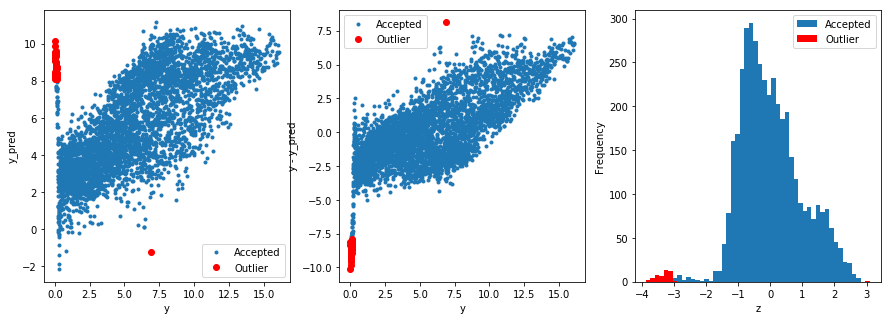

In [12]:
outliers = find_outliers(Ridge(), X, y_train.time_to_failure)

X_outliers = X.loc[outliers]
y_outliers = y_train.loc[outliers]
X_t = X.drop(outliers)
y_t = y_train.drop(outliers)

In [13]:
NUM_EVALS = 1000
N_FOLDS = 5
XGB_MAX_LEAVES = 2**12 
XGB_MAX_DEPTH = 50
EVAL_METRIC_XGB_REG = 'mae'
LGBM_MAX_LEAVES = 2**11
LGBM_MAX_DEPTH = 35
EVAL_METRIC_LGBM_REG = 'mae'

In [14]:
def quick_hyperopt(data, labels, package='lgbm', num_evals=NUM_EVALS, diagnostic=False):
    
    #==========
    #LightGBM
    #==========
    
    if package=='lgbm':
        
        print('Running {} rounds of LightGBM parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth',
                          'num_leaves',
                          'max_bin',
                          'min_data_in_leaf',
                          'min_data_in_bin']
        
        def objective(space_params):
            
            #cast integer params from float to int
            for param in integer_params:
                space_params[param] = int(space_params[param])
            
            #extract nested conditional parameters
            if space_params['boosting']['boosting'] == 'goss':
                top_rate = space_params['boosting'].get('top_rate')
                other_rate = space_params['boosting'].get('other_rate')
                #0 <= top_rate + other_rate <= 1
                top_rate = max(top_rate, 0)
                top_rate = min(top_rate, 0.5)
                other_rate = max(other_rate, 0)
                other_rate = min(other_rate, 0.5)
                space_params['top_rate'] = top_rate
                space_params['other_rate'] = other_rate
            
            subsample = space_params['boosting'].get('subsample', 1.0)
            space_params['boosting'] = space_params['boosting']['boosting']
            space_params['subsample'] = subsample
            
            #for classification, set stratified=True and metrics=EVAL_METRIC_LGBM_CLASS
            cv_results = lgb.cv(space_params, train, num_boost_round=100, nfold = N_FOLDS, stratified=False,
                                early_stopping_rounds=100, metrics=EVAL_METRIC_LGBM_REG, seed=42)
            
            best_loss = cv_results['l1-mean'][-1] #'l2-mean' for rmse
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['auc-mean'][-1]
            #if necessary, replace 'auc-mean' with '[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = lgb.Dataset(data, labels)
                
        #integer and string parameters, used with hp.choice()
        boosting_list = [{'boosting': 'gbdt',
                          'subsample': hp.uniform('subsample', 0.5, 1)},
                         {'boosting': 'goss',
                          'subsample': 1.0,
                         'top_rate': hp.uniform('top_rate', 0, 0.5),
                         'other_rate': hp.uniform('other_rate', 0, 0.5)}] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['MAE'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc'] #modify as required for other classification metrics
        objective_list_reg = ['huber',  'gamma', 'tweedie', 'fair']
        objective_list_class = ['binary', 'cross_entropy']
        #for classification set objective_list = objective_list_class
        objective_list = objective_list_reg

        space ={'boosting' : hp.choice('boosting', boosting_list),
                'num_leaves' : hp.quniform('num_leaves', 2, LGBM_MAX_LEAVES, 1),
                'max_depth': hp.quniform('max_depth', 2, LGBM_MAX_DEPTH, 1),
                'max_bin': hp.quniform('max_bin', 32, 255, 1),
                'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
                'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
                'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),
                'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
                'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'metric' : hp.choice('metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
            }
        
        #optional: activate GPU for LightGBM
        #follow compilation steps here:
        #https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm/
        #then uncomment lines below:
        #space['device'] = 'gpu'
        #space['gpu_platform_id'] = 0,
        #space['gpu_device_id'] =  0

        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
                
        #fmin() will return the index of values chosen from the lists/arrays in 'space'
        #to obtain actual values, index values are used to subset the original lists/arrays
        best['boosting'] = boosting_list[best['boosting']]['boosting']#nested dict, index twice
        best['metric'] = metric_list[best['metric']]
        best['objective'] = objective_list[best['objective']]
                
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        if diagnostic:
            return(best, trials)
        else:
            return(best)
    
    #==========
    #XGBoost
    #==========
    
    if package=='xgb':
        
        print('Running {} rounds of XGBoost parameter optimisation:'.format(num_evals))
        #clear space
        gc.collect()
        
        integer_params = ['max_depth']
        
        def objective(space_params):
            
            for param in integer_params:
                space_params[param] = int(space_params[param])
                
            #extract multiple nested tree_method conditional parameters
            #libera te tutemet ex inferis
            if space_params['tree_method']['tree_method'] == 'hist':
                max_bin = space_params['tree_method'].get('max_bin')
                space_params['max_bin'] = int(max_bin)
                if space_params['tree_method']['grow_policy']['grow_policy']['grow_policy'] == 'depthwise':
                    grow_policy = space_params['tree_method'].get('grow_policy').get('grow_policy').get('grow_policy')
                    space_params['grow_policy'] = grow_policy
                    space_params['tree_method'] = 'hist'
                else:
                    max_leaves = space_params['tree_method']['grow_policy']['grow_policy'].get('max_leaves')
                    space_params['grow_policy'] = 'lossguide'
                    space_params['max_leaves'] = int(max_leaves)
                    space_params['tree_method'] = 'hist'
            else:
                space_params['tree_method'] = space_params['tree_method'].get('tree_method')
                
            #for classification replace EVAL_METRIC_XGB_REG with EVAL_METRIC_XGB_CLASS
            cv_results = xgb.cv(space_params, train, num_boost_round=100, nfold=N_FOLDS, metrics=[EVAL_METRIC_XGB_REG],
                             early_stopping_rounds=100, stratified=False, seed=42)
            
            best_loss = cv_results['test-mae-mean'].iloc[-1] #or 'test-rmse-mean' if using RMSE
            #for classification, comment out the line above and uncomment the line below:
            #best_loss = 1 - cv_results['test-auc-mean'].iloc[-1]
            #if necessary, replace 'test-auc-mean' with 'test-[your-preferred-metric]-mean'
            return{'loss':best_loss, 'status': STATUS_OK }
        
        train = xgb.DMatrix(data, labels)
        
        #integer and string parameters, used with hp.choice()
        boosting_list = ['gbtree', 'gblinear'] #if including 'dart', make sure to set 'n_estimators'
        metric_list = ['mae'] 
        #for classification comment out the line above and uncomment the line below
        #metric_list = ['auc']
        #modify as required for other classification metrics classification
        
        tree_method = [{'tree_method' : 'exact'},
               {'tree_method' : 'approx'},
               {'tree_method' : 'hist',
                'max_bin': hp.quniform('max_bin', 2**3, 2**7, 1),
                'grow_policy' : {'grow_policy': {'grow_policy':'depthwise'},
                                'grow_policy' : {'grow_policy':'lossguide',
                                                  'max_leaves': hp.quniform('max_leaves', 32, XGB_MAX_LEAVES, 1)}}}]
        
        #if using GPU, replace 'exact' with 'gpu_exact' and 'hist' with
        #'gpu_hist' in the nested dictionary above
        
        objective_list_reg = ['reg:linear']
        objective_list_class = ['reg:logistic', 'binary:logistic']
        #for classification change line below to 'objective_list = objective_list_class'
        objective_list = objective_list_reg
        
        space ={'boosting' : hp.choice('boosting', boosting_list),
                'tree_method' : hp.choice('tree_method', tree_method),
                'max_depth': hp.quniform('max_depth', 2, XGB_MAX_DEPTH, 1),
                'reg_alpha' : hp.uniform('reg_alpha', 0, 5),
                'reg_lambda' : hp.uniform('reg_lambda', 0, 5),
                'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
                'gamma' : hp.uniform('gamma', 0, 5),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'eval_metric' : hp.choice('eval_metric', metric_list),
                'objective' : hp.choice('objective', objective_list),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.01),
                'colsample_bynode' : hp.quniform('colsample_bynode', 0.1, 1, 0.01),
                'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.1, 1, 0.01),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'nthread' : 3
            }
        
        trials = Trials()
        best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=num_evals, 
                    trials=trials)
        
        best['tree_method'] = tree_method[best['tree_method']]['tree_method']
        best['boosting'] = boosting_list[best['boosting']]
        best['eval_metric'] = metric_list[best['eval_metric']]
        best['objective'] = objective_list[best['objective']]
        
        #cast floats of integer params to int
        for param in integer_params:
            best[param] = int(best[param])
        if 'max_leaves' in best:
            best['max_leaves'] = int(best['max_leaves'])
        if 'max_bin' in best:
            best['max_bin'] = int(best['max_bin'])
        
        print('{' + '\n'.join('{}: {}'.format(k, v) for k, v in best.items()) + '}')
        
        if diagnostic:
            return(best, trials)
        else:
            return(best)

In [15]:
lgb_params = quick_hyperopt(X_t, y_t, package='lgbm', num_evals=500)

Running 500 rounds of LightGBM parameter optimisation:
100%|██████████| 500/500 [21:03<00:00,  2.61s/it, best loss: 1.971265063144043]
{bagging_fraction: 0.75
boosting: goss
feature_fraction: 0.99
lambda_l1: 2.8525910168234634
lambda_l2: 2.260249028234329
learning_rate: 0.18372282527182085
max_bin: 193
max_depth: 17
metric: MAE
min_data_in_bin: 41
min_data_in_leaf: 40
min_gain_to_split: 3.42
num_leaves: 1992
objective: huber
other_rate: 0.4399969362781391
top_rate: 0.29229534308486604}


In [16]:
lgb_params = {'bagging_fraction': 0.75,
             'boosting': 'goss',
             'feature_fraction': 0.99,
             'lambda_l1': 2.8525910168234634,
             'lambda_l2': 2.260249028234329,
             'learning_rate': 0.18372282527182085,
             'max_bin': 193,
             'max_depth': 17,
             'metric': 'MAE',
             'min_data_in_bin': 41,
             'min_data_in_leaf': 40,
             'min_gain_to_split': 3.42,
             'num_leaves': 1992,
             'objective': 'huber',
             'other_rate': 0.4399969362781391,
             'top_rate': 0.29229534308486604}

{'bagging_fraction': 0.75,
 'boosting': 'goss',
 'feature_fraction': 0.99,
 'lambda_l1': 2.8525910168234634,
 'lambda_l2': 2.260249028234329,
 'learning_rate': 0.18372282527182085,
 'max_bin': 193,
 'max_depth': 17,
 'metric': 'MAE',
 'min_data_in_bin': 41,
 'min_data_in_leaf': 40,
 'min_gain_to_split': 3.42,
 'num_leaves': 1992,
 'objective': 'huber',
 'other_rate': 0.4399969362781391,
 'top_rate': 0.29229534308486604}

In [17]:
MAE = 0
lgb_preds = np.zeros(len(X_test))
oof_lgb = np.zeros(len(X_t))
feature_importance_df = pd.DataFrame()


n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for fold, (train_idx, valid_idx) in enumerate(folds.split(y_t)):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    model = lgb.LGBMRegressor(**lgb_params, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=200)
    val_preds = model.predict(X_valid)
    oof_lgb[valid_idx] = val_preds
    MAE += mean_absolute_error(y_valid, val_preds) / n_fold
    lgb_preds += model.predict(X_test, num_iteration=model.best_iteration_) / n_fold
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_t.columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)
    
print('CV score: {}'.format(MAE))

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[86]	training's l1: 1.60759	valid_1's l1: 2.01436
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[48]	training's l1: 1.741	valid_1's l1: 2.00593
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[64]	training's l1: 1.66502	valid_1's l1: 1.90236
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[76]	training's l1: 1.60454	valid_1's l1: 1.99678
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[114]	training's l1: 1.57154	valid_1's l1: 2.05359
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[141]	training's l1: 1.58698	valid_1's l1: 1.89048
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[103]	training

In [18]:
feature_importance_df

,feature,importance,fold
0,0,113,1
1,1,81,1
2,2,121,1
3,3,33,1
4,4,1,1
5,5,8,1
6,6,0,1
7,7,0,1
8,8,4,1
9,9,40,1


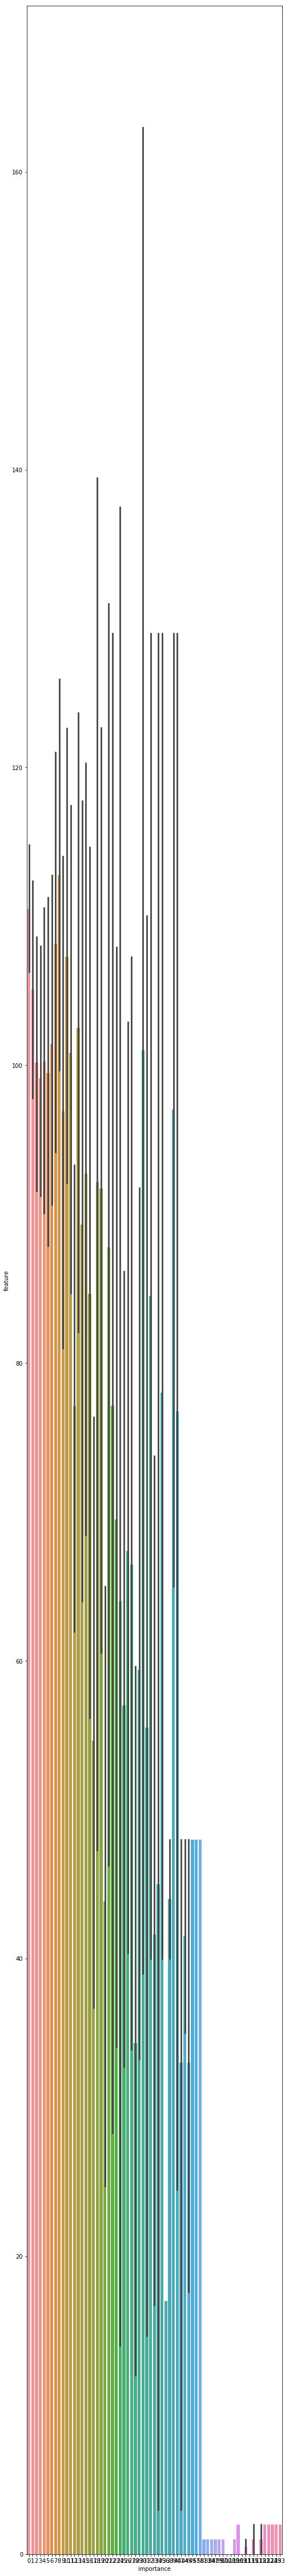

In [19]:
feature_importance_df["importance"] /= n_fold

# cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index[:50]
# best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(8, 82))
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by="importance", ascending=False))
plt.show()

In [20]:
xgb_params = quick_hyperopt(X_t, y_t, package='xgb', num_evals=500, diagnostic=False)

Running 500 rounds of XGBoost parameter optimisation:
100%|███████| 500/500 [3:58:53<00:00, 32.65s/it, best loss: 1.9942381999999998]
{boosting: gblinear
colsample_bylevel: 0.68
colsample_bynode: 0.59
colsample_bytree: 0.93
eval_metric: mae
gamma: 2.131617873803861
learning_rate: 0.02566547625144134
max_depth: 5
min_child_weight: 4.574557859567123
objective: reg:linear
reg_alpha: 1.5426477198205795
reg_lambda: 0.43942350713364753
subsample: 0.75
tree_method: approx}


In [21]:
xgb_params = {'boosting': 'gblinear',
             'colsample_bylevel': 0.68,
             'colsample_bynode': 0.59,
             'colsample_bytree': 0.93,
             'eval_metric': 'mae',
             'gamma': 2.131617873803861,
             'learning_rate': 0.02566547625144134,
             'max_depth': 5,
             'min_child_weight': 4.574557859567123,
             'objective': 'reg:linear',
             'reg_alpha': 1.5426477198205795,
             'reg_lambda': 0.43942350713364753,
             'subsample': 0.75,
             'tree_method': 'approx'}

{'boosting': 'gblinear',
 'colsample_bylevel': 0.68,
 'colsample_bynode': 0.59,
 'colsample_bytree': 0.93,
 'eval_metric': 'mae',
 'gamma': 2.131617873803861,
 'learning_rate': 0.02566547625144134,
 'max_depth': 5,
 'min_child_weight': 4.574557859567123,
 'objective': 'reg:linear',
 'reg_alpha': 1.5426477198205795,
 'reg_lambda': 0.43942350713364753,
 'subsample': 0.75,
 'tree_method': 'approx'}

In [23]:
n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)

MAE = 0
xgb_preds = np.zeros(len(X_test))
oof_xgb = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    model = xgb.XGBRegressor(**xgb_params, n_estimators=20000, n_jobs=3)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=10000, early_stopping_rounds=200)
    val_preds = model.predict(X_valid)
    oof_xgb[valid_idx] = val_preds
    MAE += mean_absolute_error(y_valid, val_preds) / n_fold
    xgb_preds += model.predict(X_test) / n_fold
    
print('CV score: {}'.format(MAE))

[0]	validation_0-mae:5.12214	validation_1-mae:5.24421
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[179]	validation_0-mae:1.39699	validation_1-mae:2.00923

[0]	validation_0-mae:5.15828	validation_1-mae:4.90576
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[77]	validation_0-mae:1.73039	validation_1-mae:2.02823

[0]	validation_0-mae:5.15411	validation_1-mae:4.94336
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 200 rounds.
Stopping. Best iteration:
[85]	validation_0-mae:1.68974	validation_1-mae:1.91551

[0]	validation_0-mae:5.11914	validation_1-mae:5.25781
Multiple eval metrics have been passed: 'validation_1-mae' will

In [19]:
xgb_preds.shape

(2624,)

In [ ]:
# GradientBoostingRegressor

In [ ]:
def objective_gbm(params):
    
    MAE = 0
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_idx, valid_idx in folds.split(y_t):
    #     print(train_idx)
        X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
        y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
        model = GradientBoostingRegressor(**params, criterion='mse')
        model.fit(X_train, y_train.values)
        val_preds = model.predict(X_valid)
        MAE += mean_absolute_error(y_valid, val_preds) / n_fold

    return {'loss': MAE, 'status': STATUS_OK}

space = {'loss': hp.choice('loss', ['ls', 'lad', 'huber', 'quantile']),
         'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
         'n_estimators': hp.choice('n_estimators', range(100, 5000)),
         'max_depth': hp.choice('max_depth', range(3, 30)),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
         'min_samples_split': hp.uniform('min_samples_split', 0, 1),
         'max_features': hp.choice('max_features', range(1, 200)),
         'alpha': hp.uniform('alpha', 0, 1)}

gbm_params = fmin(fn=objective_gbm,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=1000)

gbm_params['loss'] = ['ls', 'lad', 'huber', 'quantile'][gbm_params['loss']]

In [68]:
gbm_params = {'learning_rate': 0.01,
              'loss': 'ls',
              'max_depth': 20,
              'n_estimators': 500,
              'subsample': 0.85,
              'n_iter_no_change': 200,
              'validation_fraction': 0.1}

In [ ]:
MAE = 0
gbm_preds = np.zeros(len(X_test))
oof_gbm = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    gbm = GradientBoostingRegressor(**gbm_params, verbose=1)
    gbm.fit(X_train, y_train)
    val_preds = gbm.predict(X_valid)
    oof_gbm[valid_idx] = val_preds
    MAE += mean_absolute_error(y_valid, val_preds) / n_fold
    gbm_preds += gbm.predict(X_test) / n_fold
    
print('CV score: {}'.format(MAE))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1          13.0410           0.1535           15.99m
         2          12.6233           0.1587           15.69m
         3          12.5533           0.1283           15.60m
         4          12.3553           0.1358           15.84m
         5          11.8295           0.1375           15.82m
         6          11.7957           0.1370           15.83m
         7          11.6441           0.1198           15.74m
         8          11.5365           0.1266           15.63m
         9          11.2204           0.1196           15.55m
        10          11.0034           0.1117           15.54m
        20           9.1599           0.0957           15.18m
        30           7.4436           0.0904           14.88m
        40           6.3030           0.0681           14.58m
        50           5.2279           0.0532           14.18m
        60           4.3015           0.0477           13.85m
       

In [ ]:
# RandomForestRegressor

In [26]:
def objective_rf(params):
    
    model = RandomForestRegressor(criterion='mae')
    scores = cross_val_score(model, X_t, y_t, cv=3, scoring='neg_mean_absolute_error')
    MAE = -scores.mean()
    return {'loss': MAE, 'status': STATUS_OK}

space = {'n_estimators': hp.choice('n_estimators', range(20, 2000)),
         'max_depth': hp.choice('max_depth', range(3, 50)), 
         'min_samples_split': hp.choice('min_samples_split', range(2, 200)), 
         'min_samples_leaf': hp.choice('min_samples_leaf', range(2, 100)),
         'max_features': hp.choice('max_features', range(3, 100)),
         'n_jobs': -1}

rf_params = fmin(fn=objective_rf,
                 space=space,
                 algo=tpe.suggest,
                 max_evals=1000)

 51%|█ | 509/1000 [15:23:06<15:15:00, 111.81s/it, best loss: 2.186292097403931]


KeyboardInterrupt: 

In [ ]:
rf_params

In [ ]:
MSE = 0
rf_preds = np.zeros(len(X_test))
oof_rf = np.zeros(len(X_t))
scores = []

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
#     print(train_idx)
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    rf = RandomForestRegressor(**rf_params, criterion='mae')
    rf.fit(X_train, y_train)
    val_preds = rf.predict(X_valid)
    oof_rf[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    rf_preds += rf.predict(X_test) / n_fold
    scores.append()
    
print('CV score: {}, std: {}'.format(MSE, np.std(scores)))

In [ ]:
# kernel ridge

In [ ]:
def objective_kr(params):
    
    MSE = 0
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_idx, valid_idx in folds.split(y_t):
    #     print(train_idx)
        X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
        y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
        model = KernelRidge(**params)
        model.fit(X_train, y_train)
        val_preds = model.predict(X_valid)
        MSE += mean_squared_error(y_valid, val_preds) / n_fold

    return {'loss': MSE, 'status': STATUS_OK}

space = {'alpha': hp.uniform('alpha', 0.01, 10),
         'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly']),
         'gamma': hp.uniform('gamma', 0.01, 1),
         'degree': hp.choice('degree', range(1, 5)),
         'coef0': hp.uniform('coef0', 0, 10)}

kr_params = fmin(fn=objective_kr,
                 space=space,
                 algo=tpe.suggest,
                 max_evals=1000)

kr_params['kernel'] = ['linear', 'rbf', 'poly'][kr_params['kernel']]

In [ ]:
kr_params

In [ ]:
MSE = 0
kr_preds = np.zeros(len(X_test))
oof_kr = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    kr = KernelRidge(**kr_params)
    kr.fit(X_train, y_train)
    val_preds = kr.predict(X_valid)
    oof_kr[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    kr_preds += kr.predict(X_test) / n_fold
    
print('CV score: {}'.format(MSE))

In [ ]:
# nusvr

In [ ]:
svr_params1 = {'gamma': 'scale', 'nu': 0.9, 'C': 10.0, 'tol': 0.01}

In [ ]:
MSE = 0
svr_preds1 = np.zeros(len(X_test))
oof_svr1 = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    svr1 = NuSVR(**svr_params1)
    svr1.fit(X_train, y_train)
    val_preds = svr1.predict(X_valid)
    oof_svr1[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    svr_preds1 += svr1.predict(X_test) / n_fold
    
print('CV score: {}'.format(MSE))

In [ ]:
svr_params2 = {'gamma': 'scale', 'nu': 0.7, 'C': 1.0, 'tol': 0.01}

In [ ]:
MSE = 0
svr_preds2 = np.zeros(len(X_test))
oof_svr2 = np.zeros(len(X_t))

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
for train_idx, valid_idx in folds.split(y_t):
    X_train, X_valid = X_t.iloc[train_idx], X_t.iloc[valid_idx]
    y_train, y_valid = y_t.iloc[train_idx], y_t.iloc[valid_idx]
    svr2 = NuSVR(**svr_params2)
    svr2.fit(X_train, y_train)
    val_preds = svr2.predict(X_valid)
    oof_svr2[valid_idx] = val_preds
    MSE += mean_squared_error(y_valid, val_preds) / n_fold
    svr_preds2 += svr2.predict(X_test) / n_fold
    
print('CV score: {}'.format(MSE))

In [21]:
submission = pd.read_csv('D:/kaggle/earthquake/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = xgb_preds
submission.to_csv('xgboost_hyperopt3.csv', index=True)